In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install torchinfo
# 安装torchinfo 以便查看网络参数

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchinfo import summary
import torchvision
# 每次生成固定的随机数方便复现
torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 一般将torch.backends.cudnn.benchmark设为True就可以大大提升卷积神经网络的运行速度
torch.backends.cudnn.benchmark = True
print(device)

cuda


In [4]:
# 加载训练集和测试集
train_dataset = torchvision.datasets.MNIST(
    root='dataset/',
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True
)

test_dataset = torchvision.datasets.MNIST(
    root='dataset/',
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=True
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    shuffle=True,
    batch_size=256
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=256,
    shuffle=False
)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /usr/local/src/pytorch/torch/csrc/utils/tensor_numpy.cpp:174.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
# 定义教师网络使其隐含层很大
class TeacherModel(nn.Module):
    def __init__(self, in_channel=1, num_classes=10):
        super(TeacherModel, self).__init__()
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(28*28, 1200)
        self.fc2 = nn.Linear(1200, 1200)
        self.fc3 = nn.Linear(1200, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu(self.dropout(self.fc1(x)))
        x = self.relu(self.dropout(self.fc2(x)))
        x = self.fc3(x)
        return x

teacher_net = TeacherModel()
teacher_net = teacher_net.to(device)
summary(teacher_net)

Layer (type:depth-idx)                   Param #
TeacherModel                             --
├─ReLU: 1-1                              --
├─Linear: 1-2                            942,000
├─Linear: 1-3                            1,441,200
├─Linear: 1-4                            12,010
├─Dropout: 1-5                           --
Total params: 2,395,210
Trainable params: 2,395,210
Non-trainable params: 0

In [6]:
# techernet选用交叉熵损失
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(teacher_net.parameters(), lr=1e-4)

In [7]:
tea_acc_list = []
epochs = 20
for epoch in range(epochs):
    teacher_net.train()
    for data, target in tqdm(train_dataloader):
        data = data.to(device)
        target = target.to(device)
        preds = teacher_net(data)
        loss = criterion(preds, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    teacher_net.eval()
    # 会使用model.eval()切换到测试模式，在该模式下，主要用于通知dropout层和batchnorm层在train和val模式间切换
    num_correct = 0
    num_samples = 0
    # with torch.no_grad()则主要是用于停止autograd模块的工作，以起到加速和节省显存的作用，具体行为就是停止gradient计算，从而节省了GPU算力和显存
    with torch.no_grad():
        for x, y in tqdm(test_dataloader):
            x = x.to(device)
            y = y.to(device)
            preds = teacher_net(x)
            prediction = preds.max(1).indices
            num_correct += (prediction == y).sum()
            num_samples += prediction.size(0)
        acc = (num_correct / num_samples).item()
        tea_acc_list.append(acc)
    print('epoch:{}\tAaccuracy{:.4f}'.format(epoch+1, acc))

100%|██████████| 40/40 [00:00<00:00, 57.01it/s]


epoch:1	Aaccuracy0.9126


100%|██████████| 40/40 [00:00<00:00, 56.64it/s]


epoch:2	Aaccuracy0.9297


100%|██████████| 40/40 [00:00<00:00, 56.68it/s]


epoch:3	Aaccuracy0.9452


100%|██████████| 40/40 [00:00<00:00, 56.06it/s]


epoch:4	Aaccuracy0.9523


100%|██████████| 40/40 [00:00<00:00, 45.85it/s]


epoch:5	Aaccuracy0.9589


100%|██████████| 40/40 [00:00<00:00, 57.17it/s]


epoch:6	Aaccuracy0.9621


100%|██████████| 40/40 [00:00<00:00, 55.65it/s]


epoch:7	Aaccuracy0.9671


100%|██████████| 40/40 [00:00<00:00, 57.61it/s]


epoch:8	Aaccuracy0.9687


100%|██████████| 40/40 [00:00<00:00, 49.24it/s]


epoch:9	Aaccuracy0.9700


100%|██████████| 40/40 [00:00<00:00, 56.94it/s]


epoch:10	Aaccuracy0.9735


100%|██████████| 40/40 [00:00<00:00, 40.55it/s]


epoch:11	Aaccuracy0.9754


100%|██████████| 40/40 [00:00<00:00, 56.89it/s]


epoch:12	Aaccuracy0.9767


100%|██████████| 40/40 [00:00<00:00, 41.81it/s]


epoch:13	Aaccuracy0.9768


100%|██████████| 40/40 [00:00<00:00, 55.70it/s]


epoch:14	Aaccuracy0.9781


100%|██████████| 40/40 [00:00<00:00, 42.34it/s]


epoch:15	Aaccuracy0.9786


100%|██████████| 40/40 [00:00<00:00, 57.01it/s]


epoch:16	Aaccuracy0.9776


100%|██████████| 40/40 [00:00<00:00, 48.29it/s]


epoch:17	Aaccuracy0.9788


100%|██████████| 40/40 [00:00<00:00, 56.72it/s]


epoch:18	Aaccuracy0.9798


100%|██████████| 40/40 [00:00<00:00, 57.06it/s]


epoch:19	Aaccuracy0.9814


100%|██████████| 40/40 [00:00<00:00, 57.72it/s]

epoch:20	Aaccuracy0.9815


In [8]:
# 定义学生网络，隐含层要小
class StudentModel(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super(StudentModel, self).__init__()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(28*28, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, num_classes)
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu(self.dropout(self.fc1(x)))
        x = self.relu(self.dropout(self.fc2(x)))
        x = self.fc3(x)
        return x
student_net = StudentModel()
student_net = student_net.to(device)

In [9]:
# 从头训练学生网络，也是交叉熵得方法
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(student_net.parameters(), lr=1e-4)

In [10]:
stu_acc_list = []
for epoch in range(epochs):
    student_net.train()
    for data, target in tqdm(train_dataloader):
        data = data.to(device)
        target = target.to(device)
        preds = student_net(data)
        loss = criterion(preds, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    num_correct = 0
    num_samples = 0
    student_net.eval()
    with torch.no_grad():
        for x, y in tqdm(test_dataloader):
            x = x.to(device)
            y = y.to(device)
            preds = student_net(x)
            prediction = preds.max(1).indices
            num_correct += (prediction == y).sum()
            num_samples += prediction.size(0)
        acc = (num_correct / num_samples).item()
        stu_acc_list.append(acc)
    print('epoch:{}\tAaccuracy{:.4f}'.format(epoch + 1, acc))

100%|██████████| 40/40 [00:00<00:00, 55.41it/s]


epoch:1	Aaccuracy0.4441


100%|██████████| 40/40 [00:00<00:00, 57.01it/s]


epoch:2	Aaccuracy0.5944


100%|██████████| 40/40 [00:00<00:00, 57.12it/s]


epoch:3	Aaccuracy0.6566


100%|██████████| 40/40 [00:00<00:00, 57.31it/s]


epoch:4	Aaccuracy0.6953


100%|██████████| 40/40 [00:00<00:00, 56.45it/s]


epoch:5	Aaccuracy0.7242


100%|██████████| 40/40 [00:00<00:00, 56.59it/s]


epoch:6	Aaccuracy0.7391


100%|██████████| 40/40 [00:00<00:00, 52.50it/s]


epoch:7	Aaccuracy0.7653


100%|██████████| 40/40 [00:00<00:00, 56.04it/s]


epoch:8	Aaccuracy0.7824


100%|██████████| 40/40 [00:00<00:00, 57.16it/s]


epoch:9	Aaccuracy0.7873


100%|██████████| 40/40 [00:00<00:00, 56.65it/s]


epoch:10	Aaccuracy0.7984


100%|██████████| 40/40 [00:00<00:00, 42.23it/s]


epoch:11	Aaccuracy0.8180


100%|██████████| 40/40 [00:00<00:00, 57.47it/s]


epoch:12	Aaccuracy0.8255


100%|██████████| 40/40 [00:00<00:00, 56.09it/s]


epoch:13	Aaccuracy0.8324


100%|██████████| 40/40 [00:00<00:00, 57.18it/s]


epoch:14	Aaccuracy0.8343


100%|██████████| 40/40 [00:00<00:00, 56.67it/s]


epoch:15	Aaccuracy0.8418


100%|██████████| 40/40 [00:00<00:00, 54.39it/s]


epoch:16	Aaccuracy0.8459


100%|██████████| 40/40 [00:00<00:00, 57.19it/s]


epoch:17	Aaccuracy0.8494


100%|██████████| 40/40 [00:00<00:00, 56.80it/s]


epoch:18	Aaccuracy0.8515


100%|██████████| 40/40 [00:00<00:00, 42.24it/s]


epoch:19	Aaccuracy0.8583


100%|██████████| 40/40 [00:00<00:00, 53.45it/s]

epoch:20	Aaccuracy0.8596


In [11]:
#教师网络参数固定当成学习模板
teacher_net.eval()
kd_model = StudentModel()
kd_model = kd_model.to(device)
kd_model.train()
# When the distilled net had 300 or more units in each of its two hidden layers, all temperatures above 8 gave fairly similar results.
temp = 8
# hard_loss交叉熵
hard_loss = nn.CrossEntropyLoss()
alpha = 0.3
# softloss kl散度 batchmean- batchsize维度求平均值
soft_loss = nn.KLDivLoss(reduction='batchmean')
optimizer = torch.optim.Adam(kd_model.parameters(), lr=1e-4)

In [12]:
import torch.nn.functional as F
kd_acc_list = []
for epoch in range(epochs):
    kd_model.train()
    for data, target in tqdm(train_dataloader):
        data = data.to(device)
        target = target.to(device)
        with torch.no_grad():
            teacher_preds = teacher_net(data)
        student_preds = kd_model(data)
        # 以label为标签的hardloss
        student_loss = hard_loss(student_preds, target)
        # 以老师为标签的softloss
        distill_loss = soft_loss(
            F.softmax(student_preds/temp, dim=1),
            F.softmax(teacher_preds/temp, dim=1)
        )
        # hard_loss soft_loss加权求和
        loss = alpha*student_loss + (1 - alpha)*distill_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    kd_model.eval()
    num_correct = 0
    num_samples = 0
    with torch.no_grad():
        for x, y in tqdm(test_dataloader):
            x = x.to(device)
            y = y.to(device)
            preds = kd_model(x)
            prediction = preds.max(1).indices
            num_correct += (prediction == y).sum()
            num_samples += prediction.size(0)
        acc = (num_correct / num_samples).item()
        kd_acc_list.append(acc)
    print('epoch:{}\tAaccuracy{:.4f}'.format(epoch + 1, acc))

100%|██████████| 40/40 [00:00<00:00, 57.51it/s]


epoch:1	Aaccuracy0.4847


100%|██████████| 40/40 [00:00<00:00, 56.19it/s]


epoch:2	Aaccuracy0.5881


100%|██████████| 40/40 [00:00<00:00, 55.47it/s]


epoch:3	Aaccuracy0.7028


100%|██████████| 40/40 [00:00<00:00, 57.31it/s]


epoch:4	Aaccuracy0.7461


100%|██████████| 40/40 [00:00<00:00, 57.50it/s]


epoch:5	Aaccuracy0.7801


100%|██████████| 40/40 [00:00<00:00, 56.16it/s]


epoch:6	Aaccuracy0.7973


100%|██████████| 40/40 [00:00<00:00, 55.99it/s]


epoch:7	Aaccuracy0.8162


100%|██████████| 40/40 [00:00<00:00, 56.99it/s]


epoch:8	Aaccuracy0.8283


100%|██████████| 40/40 [00:00<00:00, 56.43it/s]


epoch:9	Aaccuracy0.8380


100%|██████████| 40/40 [00:01<00:00, 38.08it/s]


epoch:10	Aaccuracy0.8466


100%|██████████| 40/40 [00:01<00:00, 34.64it/s]


epoch:11	Aaccuracy0.8516


100%|██████████| 40/40 [00:00<00:00, 56.59it/s]


epoch:12	Aaccuracy0.8589


100%|██████████| 40/40 [00:00<00:00, 55.76it/s]


epoch:13	Aaccuracy0.8621


100%|██████████| 40/40 [00:00<00:00, 56.79it/s]


epoch:14	Aaccuracy0.8604


100%|██████████| 40/40 [00:00<00:00, 56.48it/s]


epoch:15	Aaccuracy0.8642


100%|██████████| 40/40 [00:00<00:00, 56.18it/s]


epoch:16	Aaccuracy0.8683


100%|██████████| 40/40 [00:00<00:00, 46.24it/s]


epoch:17	Aaccuracy0.8714


100%|██████████| 40/40 [00:00<00:00, 52.80it/s]


epoch:18	Aaccuracy0.8692


100%|██████████| 40/40 [00:00<00:00, 53.05it/s]


epoch:19	Aaccuracy0.8686


100%|██████████| 40/40 [00:00<00:00, 55.99it/s]

epoch:20	Aaccuracy0.8706


In [13]:
summary(student_net)

Layer (type:depth-idx)                   Param #
StudentModel                             --
├─ReLU: 1-1                              --
├─Dropout: 1-2                           --
├─Linear: 1-3                            15,700
├─Linear: 1-4                            420
├─Linear: 1-5                            210
Total params: 16,330
Trainable params: 16,330
Non-trainable params: 0

In [14]:
summary(kd_model)

Layer (type:depth-idx)                   Param #
StudentModel                             --
├─ReLU: 1-1                              --
├─Dropout: 1-2                           --
├─Linear: 1-3                            15,700
├─Linear: 1-4                            420
├─Linear: 1-5                            210
Total params: 16,330
Trainable params: 16,330
Non-trainable params: 0

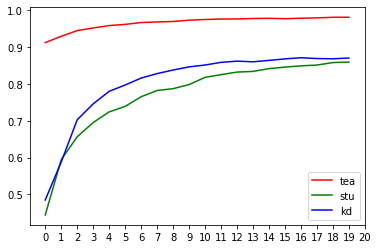

In [15]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(tea_acc_list, label='tea',color='red')
plt.plot(stu_acc_list, label='stu', color='green')
plt.plot(kd_acc_list, label='kd', color='blue')
plt.xticks([i for i in range(21)])
plt.legend()
plt.show()